In [2]:
import tensorflow as tf # 2.3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.datasets.mnist as mnist

Import les donées

In [3]:
(train_image, train_labels), (test_image, test_labels) = tf.keras.datasets.mnist.load_data()
# train_image.shape = (60000, 28, 28), train_labels.shape = (60000,)

11490434/11490434 [==============================] - 1s 0us/step


Traitement les données

In [4]:
# Normalisation les données 0 - 255 en -1 - 1
train_image = (train_image - 127.5)/127.5
test_image = (test_image - 127.5)/127.5 
# Transformation de type 
train_image = tf.cast(train_image, tf.float32)
test_image = tf.cast(test_image, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_labels = tf.cast(test_labels, tf.int64)

Créer un jeu de données 

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels)).shuffle(60000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

Construire le modèle MLP et l'entraîner 

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax') #kernel_regularizer
])

In [7]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history = model.fit(dataset,validation_data=test_dataset,epochs=10)

Epoch 1/10
235/235 [==============================] - 3s 10ms/step - loss: 0.4450 - acc: 0.8671 - val_loss: 0.2573 - val_acc: 0.9261
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: 0.2118 - acc: 0.9377 - val_loss: 0.1728 - val_acc: 0.9488
Epoch 3/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1607 - acc: 0.9518 - val_loss: 0.1424 - val_acc: 0.9583
Epoch 4/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1319 - acc: 0.9601 - val_loss: 0.1337 - val_acc: 0.9568
Epoch 5/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1093 - acc: 0.9673 - val_loss: 0.1105 - val_acc: 0.9653
Epoch 6/10
235/235 [==============================] - 2s 8ms/step - loss: 0.0977 - acc: 0.9701 - val_loss: 0.1109 - val_acc: 0.9650
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0863 - acc: 0.9737 - val_loss: 0.0996 - val_acc: 0.9690
Epoch 8/10
235/235 [==============================] - 2s 8ms/step - loss: 0

## Adversarial training with the model witch subtracted the L1 penalty

In [8]:
model_L1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax',name='dense3',kernel_regularizer=tf.keras.regularizers.L1(-0.3)) #kernel_regularizer
])

In [9]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
model_L1.compile(optimizer=optimizer,loss=loss_func,metrics=['acc'])
history_L1 = model_L1.fit(dataset,validation_data=test_dataset,epochs=10) 


Epoch 1/10
235/235 [==============================] - 3s 11ms/step - loss: -48.8060 - acc: 0.8737 - val_loss: -71.5128 - val_acc: 0.9220
Epoch 2/10
235/235 [==============================] - 2s 10ms/step - loss: -93.8894 - acc: 0.9398 - val_loss: -116.5778 - val_acc: 0.9546
Epoch 3/10
235/235 [==============================] - 2s 10ms/step - loss: -138.9333 - acc: 0.9552 - val_loss: -161.5438 - val_acc: 0.9432
Epoch 4/10
235/235 [==============================] - 2s 10ms/step - loss: -183.9809 - acc: 0.9576 - val_loss: -206.6312 - val_acc: 0.9552
Epoch 5/10
235/235 [==============================] - 2s 10ms/step - loss: -229.0388 - acc: 0.9595 - val_loss: -251.7076 - val_acc: 0.9600
Epoch 6/10
235/235 [==============================] - 3s 10ms/step - loss: -274.1416 - acc: 0.9663 - val_loss: -296.7612 - val_acc: 0.9541
Epoch 7/10
235/235 [==============================] - 3s 11ms/step - loss: -319.2208 - acc: 0.9639 - val_loss: -341.8683 - val_acc: 0.9567
Epoch 8/10
235/235 [==========

Implémenter FGSM(Fast Gradient Sign Method)
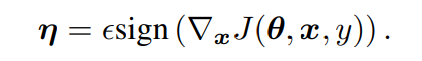

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  # Utiliser la fonction signe sur le gradient pour créer une perturbation对梯度使用sign函数，创建扰动
  signed_grad = tf.sign(gradient)
  return signed_grad

Définir une fonction pour plot les images

In [11]:
# image: Ensemble d'images originales
# label: Ensemble d'étiquette prédite par le modèle d'image d'origine
# adv_lable: Ensemble d'étiquette prédite par le modèle après l'ajout de la perturbation
# num: Le nombre d'image d'afficher
def display_images(image, label,adv_label, adv_label_L1, num = 10):
  fig = plt.figure(figsize=(2*num,3)) # figsize:指定figure的宽和高，单位为英寸
  for i in range(num):   # pre_image的shape的第一个维度就是个数，这里是num
      plt.subplot(1,num,i+1) # 几行几列的 第i+1个图片（从1开始）
      plt.imshow(image[i,:,:],cmap='gray') # + 1)/2) # 加1除2: 将生成的-1～1的图片弄到0-1之间,
      plt.title('{} -> {} -> {}'.format(label[i],adv_label[i],adv_label_L1[i]))
      plt.axis('off') # 不要坐标
  plt.show()


Ajouter la perturbations et Tester dans le jeu de test

epsilons = 0:
313/313 [==============================] - 0s 1ms/step


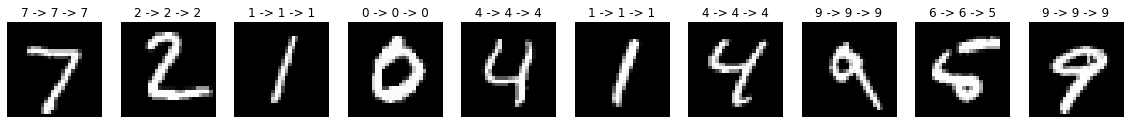

epsilons = 0.05:
313/313 [==============================] - 1s 2ms/step


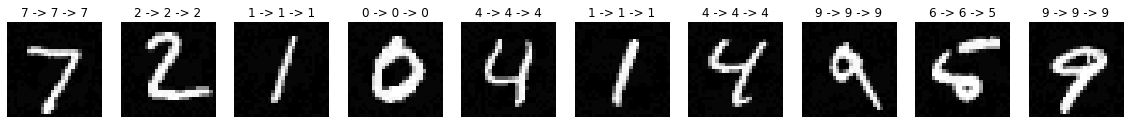

epsilons = 0.1:
313/313 [==============================] - 0s 1ms/step


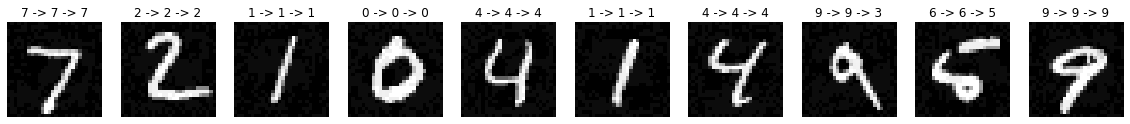

epsilons = 0.15:
313/313 [==============================] - 1s 2ms/step


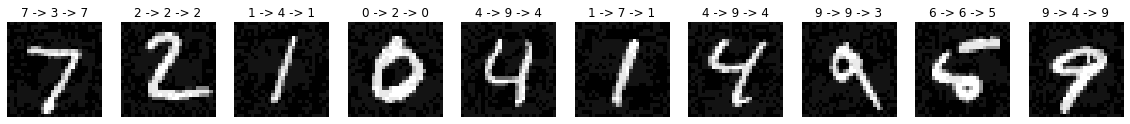

epsilons = 0.2:
313/313 [==============================] - 0s 1ms/step


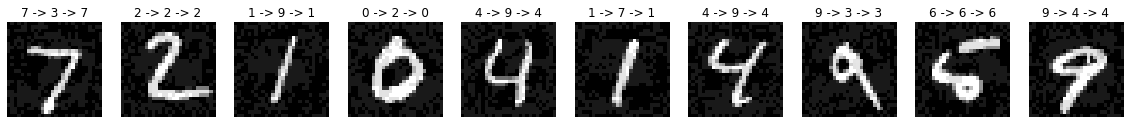

epsilons = 0.25:
313/313 [==============================] - 0s 1ms/step


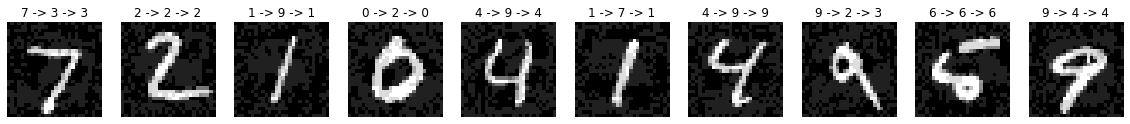

epsilons = 0.3:
313/313 [==============================] - 0s 1ms/step


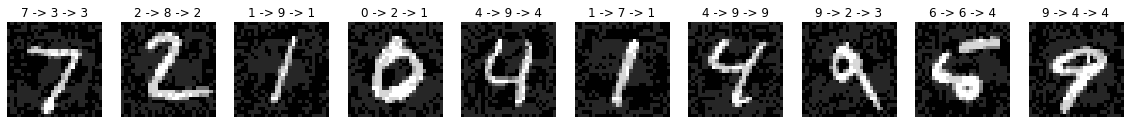

In [12]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
perturbations = create_adversarial_pattern(test_image, test_labels)
adv_acc_list = []
adv_acc_list_L1 = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Obtenir le résultat de la prédiction de l'image d'origine 获取原始图片的预测结果
  test_image = tf.clip_by_value(test_image, -1, 1)
  predict_label = model.predict(test_image)
  predict_label = np.array([np.argmax(i) for i in predict_label])
  # Générer des adversarial pattern et obtenir des résultats de prédiction 生成对抗样本，并获取预测结果
  adv_image = test_image + eps*perturbations
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  adv_predict_label = model.predict(adv_image)
  adv_predict_label = np.array([np.argmax(i) for i in adv_predict_label])

  adv_predict_label_L1 = model_L1.predict(adv_image)
  adv_predict_label_L1 = np.array([np.argmax(i) for i in adv_predict_label_L1])

  # Évaluer le modèle sur un ensemble d'exemples adversarial 在对抗样本集合中评估模型
  score = model.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score[1])

  score_L1 = model_L1.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list_L1.append(score_L1[1])
  # plot
  display_images(adv_image,predict_label,adv_predict_label, adv_predict_label_L1, 10)

# labels: model sur image originales  -> model sur adversarial exemples    -> model_L1 sur adversarial exemples

Afficher la précision en fonction d'epsilons

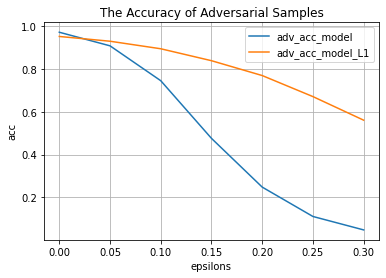

adv_acc_model [0.9715999960899353, 0.9081000089645386, 0.7451000213623047, 0.475600004196167, 0.24779999256134033, 0.11050000041723251, 0.04769999906420708]
adv_acc_model_L1 [0.9519000053405762, 0.9296000003814697, 0.8944000005722046, 0.8385999798774719, 0.7692000269889832, 0.670799970626831, 0.5605999827384949]


In [15]:
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.plot(epsilons,adv_acc_list,label='adv_acc_model')
plt.plot(epsilons,adv_acc_list_L1,label='adv_acc_model_L1')
plt.legend()
plt.grid()
plt.show()
print('adv_acc_model',adv_acc_list)
print('adv_acc_model_L1',adv_acc_list_L1)

## Adversarial training with adversarial exemples


In [16]:
perturb = create_adversarial_pattern(train_image, train_labels)
train_adv = train_image+0.3*perturb
train_train_adv = tf.concat([train_image, train_adv], 0) #train_image + train_image with perturbation （120000 images） 
labels_label_adv = tf.concat([train_labels, train_labels], 0)  # 2*labels，因为加了扰动的图像还属于该标签

dataset_adv = tf.data.Dataset.from_tensor_slices((train_train_adv, labels_label_adv)).shuffle(120000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels)).batch(256)

In [17]:
# model training with clean exemples and adversarial exemples 
model_adv = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])
optimizer_adv = tf.keras.optimizers.Adam()
loss_func_adv = tf.keras.losses.SparseCategoricalCrossentropy()
model_adv.compile(optimizer=optimizer,loss=loss_func_adv,metrics=['acc'])
history = model_adv.fit(dataset_adv,validation_data=test_dataset,epochs=10) # 用新合并的对抗训练集训练

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 0.2935 - acc: 0.9114 - val_loss: 0.2246 - val_acc: 0.9316
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1312 - acc: 0.9614 - val_loss: 0.1870 - val_acc: 0.9410
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.1003 - acc: 0.9699 - val_loss: 0.1688 - val_acc: 0.9477
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.0826 - acc: 0.9751 - val_loss: 0.1360 - val_acc: 0.9576
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0733 - acc: 0.9779 - val_loss: 0.1344 - val_acc: 0.9576
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0643 - acc: 0.9797 - val_loss: 0.1322 - val_acc: 0.9582
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0577 - acc: 0.9825 - val_loss: 0.1421 - val_acc: 0.9570
Epoch 8/10
469/469 [==============================] - 3s 6ms/step - loss: 0.

epsilons = 0:
313/313 [==============================] - 0s 1ms/step


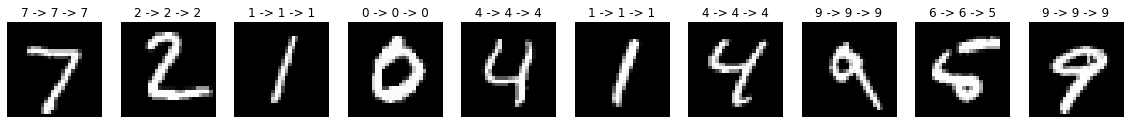

epsilons = 0.05:
313/313 [==============================] - 0s 1ms/step


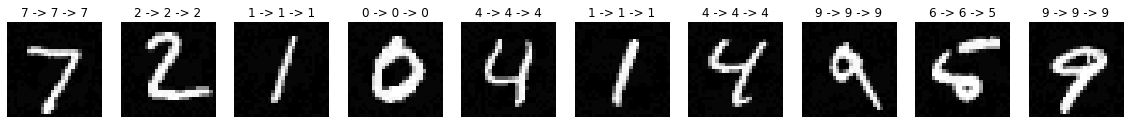

epsilons = 0.1:
313/313 [==============================] - 0s 1ms/step


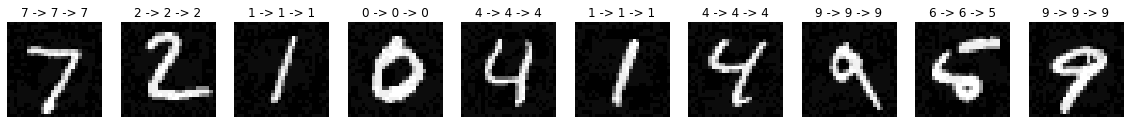

epsilons = 0.15:
313/313 [==============================] - 0s 1ms/step


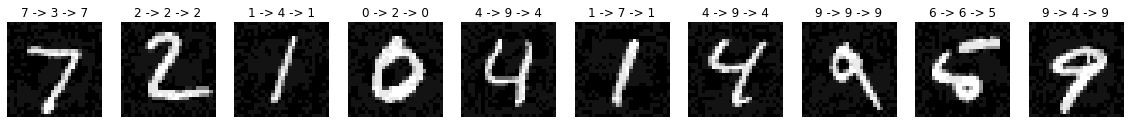

epsilons = 0.2:
313/313 [==============================] - 0s 1ms/step


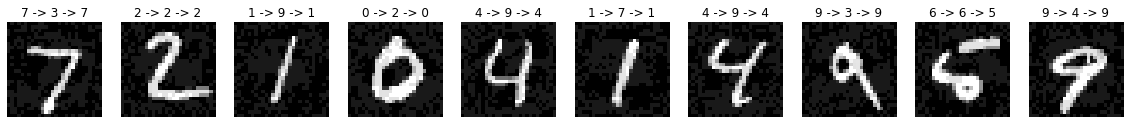

epsilons = 0.25:
313/313 [==============================] - 0s 1ms/step


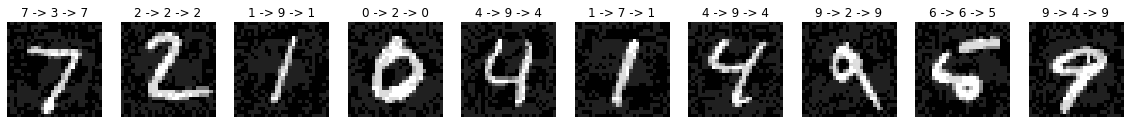

epsilons = 0.3:
313/313 [==============================] - 0s 1ms/step


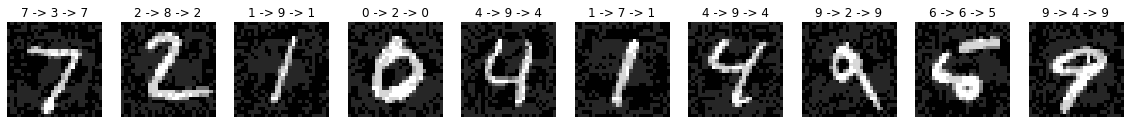

In [18]:
# Tester dans les différentes valeurs d'epsilon 在不同的epsilons进行测试
epsilons = [0,0.05,0.10,0.15,0.20,0.25,0.30]
adv_acc_list = []
acc_list = []
for i, eps in enumerate(epsilons):
  print("epsilons = {}:".format(eps))
  # Générer des adversarial pattern
  adv_image = test_image + eps*perturbations      
  adv_image = tf.clip_by_value(adv_image, -1, 1)
  # Obtenir le résultat de la prédiction de l'image d'origine 
  pred = model.predict(test_image) 
  pred = np.array([np.argmax(i) for i in pred])
  # Obtenir le résultat de la prédiction de adversarial exemples en utilisant model original
  pred_adv1 = model.predict(adv_image) 
  pred_adv1 = np.array([np.argmax(i) for i in pred_adv1])
  # Obtenir le résultat de la prédiction de adversarial exemples en utilisant model avec adversarial training 
  pred_adv2 = model_adv.predict(adv_image)
  pred_adv2 = np.array([np.argmax(i) for i in pred_adv2])
  # Évaluer le modèle sur un ensemble d'exemples adversarial 
  score1 = model.evaluate(adv_image,test_labels,verbose=0)
  acc_list.append(score1[1])
  score2 = model_adv.evaluate(adv_image,test_labels,verbose=0)
  adv_acc_list.append(score2[1])
  # plot
  display_images(adv_image,pred,pred_adv1,pred_adv2, 10)

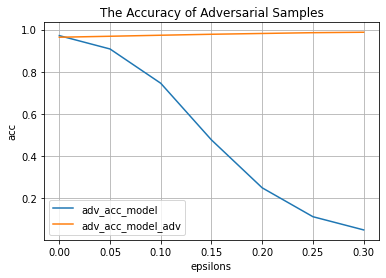

acc [0.9715999960899353, 0.9081000089645386, 0.7451000213623047, 0.475600004196167, 0.24779999256134033, 0.11050000041723251, 0.04769999906420708]
acc [0.9639999866485596, 0.9685999751091003, 0.9735000133514404, 0.9781000018119812, 0.9818999767303467, 0.9855999946594238, 0.9876999855041504]


In [20]:
plt.figure()
plt.plot(epsilons,acc_list,label='adv_acc_model')
plt.plot(epsilons,adv_acc_list,label='adv_acc_model_adv')
plt.title("The Accuracy of Adversarial Samples")
plt.xlabel("epsilons")
plt.ylabel("acc")
plt.legend()
plt.grid()
plt.show()
print('acc',acc_list)
print('acc',adv_acc_list)